In [4]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

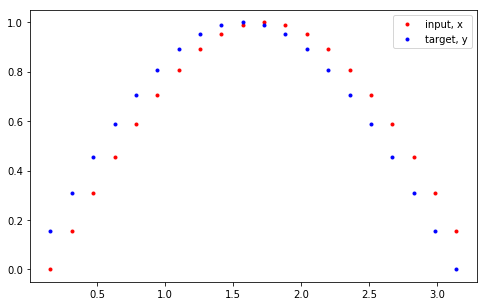

In [5]:
plt.figure(figsize=(8,5))

seq_length = 20

# generate data
time_steps = np.linspace(0, np.pi, seq_length+1)
data = np.sin(time_steps)
data.resize((seq_length+1, 1))

x = data[:-1]
y = data[1:]

# display data
plt.plot(time_steps[1:], x, 'r.', label="input, x")
plt.plot(time_steps[1:], y, 'b.', label="target, y")

plt.legend(loc='best')
plt.show()

In [6]:
# RNN
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # batch_first = True, dimensi pertama dari input dan output adalah sesuai dengan batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # fc layers
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        
        # RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        
        # reshape
        r_out = r_out.view(-1, self.hidden_dim)
        
        # output
        output = self.fc(r_out)
        
        return output, hidden    

In [7]:
# check input dan output dimension
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate data test
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0)
print('Input size: ', test_input.size())

# test output
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [8]:
# tentukan hyperparameter

input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

# instantiate
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [9]:
# loss dan optimization
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

In [12]:
# lakukan training

def train(rnn, n_steps, print_every):
    # initialize hidden state
    hidden = None
    
    for batch_i, step in enumerate(range(n_steps)):
        # tentukan training data
        time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length+1)
        data = np.sin(time_steps)
        data.resize((seq_length+1, 1)) # input_size = 1
        
        x = data[:-1]
        y = data[1:]
        
        # convert data ke bentuk Tensor
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        # output dari rnn
        prediction, hidden = rnn(x_tensor, hidden)
        
        hidden = hidden.data
        
        # hitung loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tampilkan loss dan prediction
        if batch_i%print_every == 0:
            print('loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
            
    return rnn

loss:  0.5946533679962158


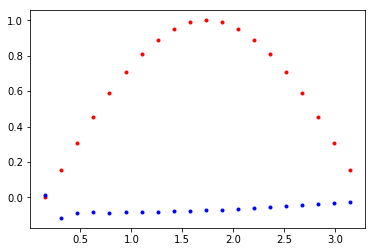

loss:  0.3517231047153473


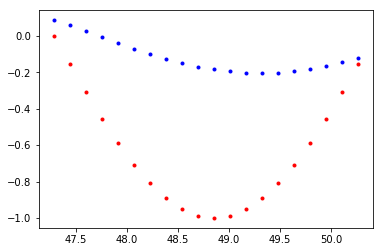

loss:  0.18438085913658142


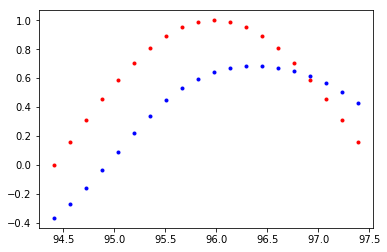

loss:  0.08160935342311859


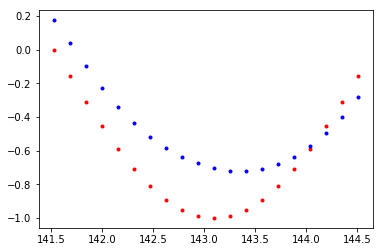

loss:  0.023362290114164352


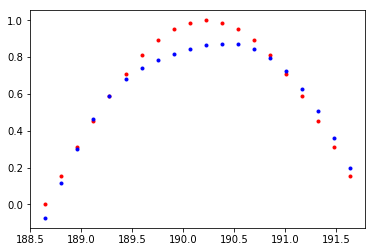

In [13]:
# train
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)